# Titanic: Machine Learning from Disaster
## *An Exploration into the Data using Python*
### Data Science on the Hill (C. Bonfield and M. Hoffman)


## Table of Contents:
1. [Introduction](#first-bullet) <br/>
2. [Loading/Examining the Data](#second-bullet) <br/>
3. [All the Features!](#third-bullet) <br/>
    3a. [Extracting Titles from Names](#third-first) <br/>
    3b. [Treating Missing Ports of Departure](#third-second) <br/>
    3c. [Handling Missing Fares](#third-third) <br/>
    3d. [Cabin Number: Relevant or Not?](#third-fourth) <br/>
    3e. [Quick Fixes](#third-fifth) <br/>
    3f. [Imputing Missing Ages](#third-sixth) <br/>
4. [Prediction](#fourth-bullet) <br/>

## 1. Introduction <a class="anchor" id="first-bullet"></a>

Insert outline of the notebook here. 

In [1]:
# Import statements
import numpy as np
import pandas as pd
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
import fancyimpute

from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

%matplotlib inline

## 2. Loading/Examining the Data <a class="anchor" id="second-bullet"></a>

In [2]:
# Load the data. 
training_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
# Examine the first few rows of data in the training set. 
training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 3. All the Features! <a class="anchor" id="third-bullet"></a>

Insert introductory discussion.

### 3a. Extracting Titles from Names <a class="anchor" id="third-first"></a>

While the **Name** feature itself may not appear to be useful at first glance, we can tease out additional features that may be useful for predicting survival on the Titanic. We will extract a **Title** from each name, as that carries information about social and marital status (which in turn may relate to survival).   

In [4]:
# Extract title from names, then assign to one of five classes.
# Function based on code from: https://www.kaggle.com/startupsci/titanic/titanic-data-science-solutions 
def add_title(data):
    data['Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    data.Title = data.Title.replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 
                                     'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    data.Title = data.Title.replace('Mlle', 'Miss')
    data.Title = data.Title.replace('Ms', 'Miss')
    data.Title = data.Title.replace('Mme', 'Mrs')
    
    # Map from strings to numerical variables.
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    
    data.Title = data.Title.map(title_mapping)
    data.Title = data.Title.fillna(0)

    return data

### 3b. Treating Missing Ports of Embarkation <a class="anchor" id="third-second"></a>

Next, let's see if there are any rows that are missing ports of embarkation. 

In [5]:
missing_emb_training = training_data[pd.isnull(training_data.Embarked) == True]
missing_emb_test = test_data[pd.isnull(test_data.Embarked) == True]

In [6]:
missing_emb_training.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [7]:
missing_emb_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


We have two passengers in the training set that are missing ports of embarkation, while we are not missing any in the test set. <br\>

The features which may allow us to assign a port of embarkation based on the data that we do have are **Pclass**, **Fare**, and **Cabin**. However, since we are missing so much of the **Cabin** column (more on that later), let's focus in on the other two.   

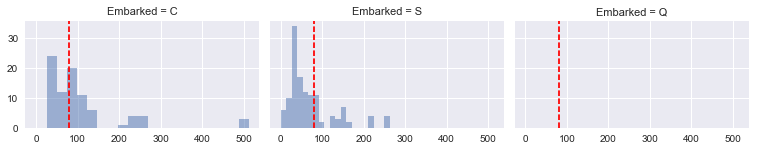

In [8]:
grid = sns.FacetGrid(training_data[training_data.Pclass == 1], col='Embarked', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Fare', alpha=.5, bins=20)
grid.map(plt.axvline, x=80.0, color='red', ls='dashed')
grid.add_legend();

Although Southampton was the most popular port of embarkation, there was a greater fraction of passengers in the first ticket class from Cherbourg who paid $80.00 for their tickets. Therefore, we will assign 'C' to the missing values for **Embarked**. We will also recast **Embarked** as a numerical feature.   

In [9]:
# Recast port of departure as numerical feature. 
def simplify_embark(data):
    # Two missing values, assign Cherbourg as port of departure.
    data.Embarked = data.Embarked.fillna('C')
    
    le = preprocessing.LabelEncoder().fit(data.Embarked)
    data.Embarked = le.transform(data.Embarked)
    
    return data

### 3c. Handling Missing Fares <a class="anchor" id="third-third"></a>

We will perform a similar analysis to see if there are any missing fares. 

In [10]:
missing_fare_training = training_data[np.isnan(training_data['Fare'])]
missing_fare_test = test_data[np.isnan(test_data['Fare'])]

In [11]:
missing_fare_training.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [12]:
missing_fare_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


This time, the **Fare** column in the training set is complete, but we are missing that information for one passenger in the test set. Since we do have **PClass** and **Embarked**, however, we will assign a fare based on the distribution of fares for those particular values of **PClass** and **Embarked**. 

/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


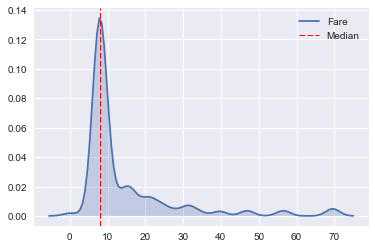

In [13]:
restricted_training = training_data[(training_data.Pclass == 3) & (training_data.Embarked == 'S')]
restricted_test = test_data[(test_data.Pclass == 3) & (test_data.Embarked == 'S')]
restricted_test = restricted_test[~np.isnan(restricted_test.Fare)] # Leave out poor Mr. Storey
combine = [restricted_training, restricted_test]
combine = pd.concat(combine)

# Find median fare, plot over resulting distribution. 
fare_med = np.median(combine.Fare)

sns.kdeplot(combine.Fare, shade=True)
plt.axvline(fare_med, color='r', ls='dashed', lw='1', label='Median')
plt.legend();

After examining the distribution of **Fare** restricted to the specified values of **Pclass** and **Fare**, we will use the median for the missing fare (as it falls very close the fare corresponding to the peak of the distribution).   

In [14]:
test_data['Fare'] = test_data['Fare'].fillna(fare_med)

### 3d. Cabin Number: Relevant or Not? <a class="anchor" id="third-fourth"></a>

When we first encountered the data, we figured that **Cabin** would be one of the most important features in predicting survival, as it would not be unreasonable to think of it as a proxy for a passenger's position on the Titanic relative to the lifeboats (distance to deck, distance to nearest stairwell, social class, etc.). 

Unfortunately, much of this data is missing:   

In [15]:
missing_cabin_training = np.size(training_data.Cabin[pd.isnull(training_data.Cabin) == True]) / np.size(training_data.Cabin) * 100.0
missing_cabin_test = np.size(test_data.Cabin[pd.isnull(test_data.Cabin) == True]) / np.size(test_data.Cabin) * 100.0

print('Percentage of Missing Cabin Numbers (Training): %0.1f' % missing_cabin_training)
print('Percentage of Missing Cabin Numbers (Test): %0.1f' % missing_cabin_test)

Percentage of Missing Cabin Numbers (Training): 77.1
Percentage of Missing Cabin Numbers (Test): 78.2


What can we do with this data (rather, the lack thereof)? 

For now, let's just pull out the first letter of each cabin number (including `NaN`s), cast them as numbers, and hope they improve the performance of our classifier. 

In [16]:
## Set of functions to transform features into more convenient format.
#
# Code performs three separate tasks:
#   (1). Pull out the first letter of the cabin feature. 
#          Code taken from: https://www.kaggle.com/jeffd23/titanic/scikit-learn-ml-from-start-to-finish
#   (2). Recasts cabin feature as number.
def simplify_cabins(data):
    data.Cabin = data.Cabin.fillna('N')
    data.Cabin = data.Cabin.apply(lambda x: x[0])
    
    #cabin_mapping = {'N': 0, 'A': 1, 'B': 1, 'C': 1, 'D': 1, 'E': 1, 
    #                 'F': 1, 'G': 1, 'T': 1}
    #data['Cabin_Known'] = data.Cabin.map(cabin_mapping)
    
    le = preprocessing.LabelEncoder().fit(data.Cabin)
    data.Cabin = le.transform(data.Cabin)
    
    return data

### 3e. Quick Fixes  <a class="anchor" id="third-fifth"></a>

Prior to the last step (which is arguably the largest one), we need to tie up a few remaining loose ends:
- Recast **Sex** as numerical feature.
- Drop unwanted features. 
    - **Name**: We've taken out the information that we need (**Title**).
    - **Ticket**: There appears to be no rhyme or reason to the data in this column, so we remove it from our analysis.
- Combine training/test data prior to age imputation.

In [17]:
# Recast sex as numerical feature. 
def simplify_sex(data):
    sex_mapping = {'male': 0, 'female': 1}
    data.Sex = data.Sex.map(sex_mapping).astype(int)
    
    return data

# Drop all unwanted features (name, ticket). 
def drop_features(data):
    return data.drop(['Name','Ticket'], axis=1)

# Perform all feature transformations. 
def transform_all(data):
    data = add_title(data)
    data = simplify_embark(data)
    data = simplify_cabins(data)
    data = simplify_sex(data)
    data = drop_features(data)
    
    return data

training_data = transform_all(training_data)
test_data = transform_all(test_data)

all_data = [training_data, test_data]
combined_data = pd.concat(all_data)

In [18]:
# Inspect data.
combined_data.head()

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title
0,22.0,7,2,7.2500,0,1,3,0,1,0.0,1
1,38.0,2,0,71.2833,0,2,1,1,1,1.0,3
2,26.0,7,2,7.9250,0,3,3,1,0,1.0,2
3,35.0,2,2,53.1000,0,4,1,1,1,1.0,3
4,35.0,7,2,8.0500,0,5,3,0,0,0.0,1


### 3f. Imputing Missing Ages  <a class="anchor" id="third-sixth"></a>

Insert discussion of missing ages.

/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


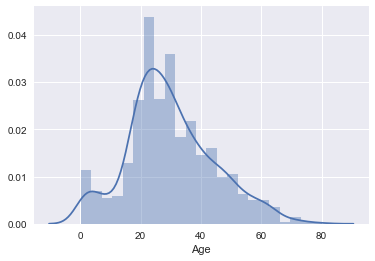

In [19]:
null_ages = pd.isnull(combined_data.Age)
known_ages = pd.notnull(combined_data.Age)
initial_dist = combined_data.Age[known_ages]

# Examine distribution of ages prior to imputation (for comparison). 
sns.distplot(initial_dist)

Insert description of age imputation. 

In [20]:
def impute_ages(data):
    drop_survived = data.drop(['Survived'], axis=1)
    column_titles = list(drop_survived)
    mice_results = fancyimpute.MICE().complete(np.array(drop_survived))
    results = pd.DataFrame(mice_results, columns=column_titles)
    results['Survived'] = list(data['Survived'])
    return results

complete_data = impute_ages(combined_data)
complete_data.Age = complete_data.Age[~(complete_data.Age).index.duplicated(keep='first')]

[MICE] Completing matrix with shape (1309, 10)
[MICE] Starting imputation round 1/110, elapsed time 0.000
[MICE] Starting imputation round 2/110, elapsed time 0.003
[MICE] Starting imputation round 3/110, elapsed time 0.004
[MICE] Starting imputation round 4/110, elapsed time 0.005
[MICE] Starting imputation round 5/110, elapsed time 0.005
[MICE] Starting imputation round 6/110, elapsed time 0.006
[MICE] Starting imputation round 7/110, elapsed time 0.007
[MICE] Starting imputation round 8/110, elapsed time 0.007
[MICE] Starting imputation round 9/110, elapsed time 0.008
[MICE] Starting imputation round 10/110, elapsed time 0.009
[MICE] Starting imputation round 11/110, elapsed time 0.010
[MICE] Starting imputation round 12/110, elapsed time 0.011
[MICE] Starting imputation round 13/110, elapsed time 0.012
[MICE] Starting imputation round 14/110, elapsed time 0.013
[MICE] Starting imputation round 15/110, elapsed time 0.013
[MICE] Starting imputation round 16/110, elapsed time 0.014
[M

/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


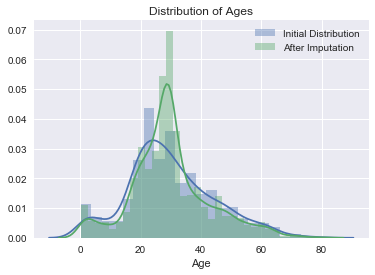

In [21]:
# Examine distribution of ages after imputation (for comparison). 
sns.distplot(initial_dist, label='Initial Distribution')
sns.distplot(complete_data.Age, label='After Imputation')
plt.title('Distribution of Ages')
plt.legend()

## 4. Prediction <a class="anchor" id="fourth-bullet"></a>

Insert description of model here. 

In [22]:
# Transform age and fare data to have mean zero and variance 1.0.
scaler = preprocessing.StandardScaler()
select = 'Age Fare'.split()
complete_data[select] = scaler.fit_transform(complete_data[select])

training_data = complete_data[:891]
test_data = complete_data[891:].drop('Survived', axis=1)

# ----------------------------------
# Support Vector Machines
droplist = 'Survived PassengerId'.split()
data = training_data.drop(droplist, axis=1)
# Define features and target values
X, y = data, training_data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

#
# # Set the parameters by cross-validation
# param_dist = {'C': scipy.stats.uniform(0.1, 1000), 'gamma': scipy.stats.uniform(.001, 1.0),
#   'kernel': ['rbf'], 'class_weight':['balanced', None]}
#
# clf = SVC()
#
# # run randomized search
# n_iter_search = 10000
# random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
#                                    n_iter=n_iter_search, n_jobs=-1, cv=4)
#
# start = time()
# random_search.fit(X, y)
# print("RandomizedSearchCV took %.2f seconds for %d candidates"
#       " parameter settings." % ((time() - start), n_iter_search))
# report(random_search.cv_results_)
# exit()

"""
RandomizedSearchCV took 4851.48 seconds for 10000 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.833 (std: 0.013)
Parameters: {'kernel': 'rbf', 'C': 107.54222939713921, 'gamma': 0.013379109762586716, 'class_weight': None}

Model with rank: 2
Mean validation score: 0.832 (std: 0.012)
Parameters: {'kernel': 'rbf', 'C': 154.85033872208422, 'gamma': 0.010852578446979289, 'class_weight': None}

Model with rank: 2
Mean validation score: 0.832 (std: 0.012)
Parameters: {'kernel': 'rbf', 'C': 142.60506747360913, 'gamma': 0.011625955252680842, 'class_weight': None}
"""

params = {'kernel': 'rbf', 'C': 107.54222939713921, 'gamma': 0.013379109762586716, 'class_weight': None}
clf = SVC(**params)
scores = cross_val_score(clf, X, y, cv=4, n_jobs=-1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

droplist = 'PassengerId'.split()
clf.fit(X,y)
predictions = clf.predict(test_data.drop(droplist, axis=1))
#print(predictions)
print('Predicted Number of Survivors: %d' % int(np.sum(predictions)))

Accuracy: 0.83 (+/- 0.02)
Predicted Number of Survivors: 163


In [23]:
# output .csv for upload
# submission = pd.DataFrame({
#         "PassengerId": test_data['PassengerId'].astype(int),
#         "Survived": predictions.astype(int)
#     })
#
# submission.to_csv('../submission.csv', index=False)